# Outlier Gene Analysis

Questions we would like to answer:
- What genes are outliers?
- How do they compare to the genes identified by Marco?
- How do they compare to the genes laballed by Adamson?
- Why do we identify certain genes as outliers vs others?
- Can we cluster these outlying genes together using PCA on the loadings or some sort of clustering?
- What outcomes are changed the "most" from the robust average profiles?


In [2]:
%matplotlib inline
import pickle as pkl
from src.config import get_interim_dir
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from bioinfokit.visuz import cluster


In [3]:
results = pkl.load(open(get_interim_dir() + "Target_bootstrapped_profiles.pkl", 'rb'))

In [4]:
samples = list(results["mcd_scores"].keys())
print(samples)

['T1', 'T2', 'T3']


In [5]:
runs = list(results["mcd_scores"][samples[0]].keys())
len(runs)

1

In [6]:
X = pd.read_pickle(get_interim_dir() + "genewise_repair_outcome_profiles.pkl")

### What are the outlying genes?

In [7]:
# def convert_sample_label(sample, run):
#     n = int(sample[3])
#     replicate = 2 if n % 2 == 0 else 1
#     if n in [1, 2]:
#         return (run, "T1", replicate)
#     elif n in [3, 4]:
#         return (run, "T2", replicate)
#     else:
#         return (run, "T3", replicate)

df = []
columns = []
for s in samples:
    for r in runs:
        df.append(results["mcd_scores"][s][r][["dist", "pvalue"]])
        columns.append((s, "dist"))
        columns.append((s, "pvalue"))

df = pd.concat(df, axis=1)
df.columns = pd.MultiIndex.from_tuples(columns)
print(df.shape)
df.head()


(18028, 6)


T1                 T2                        T3              
               dist pvalue        dist        pvalue        dist        pvalue
Gene                                                                          
Fam111a  397.345524    0.0  192.766748  0.000000e+00   87.889191  1.729943e-10
Fanci    322.337198    0.0  158.183120  0.000000e+00  124.458845  0.000000e+00
Ik       143.633285    0.0  182.062473  0.000000e+00  190.966741  0.000000e+00
Fancl    266.521391    0.0  110.688787  5.995204e-15  116.636878  1.221245e-15
Vmn2r7   201.637256    0.0  176.911192  0.000000e+00   91.575323  3.926337e-11

In [8]:
from statsmodels.stats.multitest import fdrcorrection

df_corrected = {}

for t in ["T1", "T2", "T3"]:
    df_corrected[t] = df.loc[:,[(t, "pvalue")]].dropna()
    rejected, corrected_pvalues = fdrcorrection(df_corrected[t][(t, "pvalue")], 0.05)
    df_corrected[t][(t, "rejected")] = rejected
    df_corrected[t][(t, "corrected_pvalues")] = corrected_pvalues


df_corrected = pd.concat(list(df_corrected.values()), axis=1)
df_corrected.shape

(18028, 9)

In [9]:
significant_gene_profiles = df_corrected.xs("rejected", level=1, axis=1)
significant_gene_profiles = significant_gene_profiles[significant_gene_profiles.any(axis=1)]
significant_gene_profiles.shape

(6630, 3)

In [10]:
significant_gene_profiles.sum()

T1    4449
T2    3918
T3    4205
dtype: object

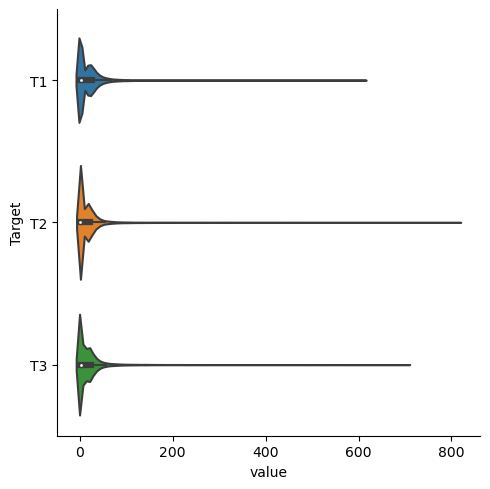

In [11]:
# to sum the scores from different classifiers, I first need to standardise the data
# see p 191, section 6.3 Outlier Analysis, Second Edition by Charu C. Aggarwal 

sns.catplot(data=df[columns].reset_index().melt(id_vars="Gene", var_name=["Target", "dist"]), kind="violin", x="value", y="Target")
plt.show()

In [12]:
# first we need to standardise the score per column
df_z = df[columns].xs("dist", level=1, axis=1)
df_z = (df_z - df_z.mean())/df_z.std()

# then we need to average the score across the runs
df_z_mean = df_z.groupby(level=0, axis=1).mean()

# finally, we take the max score
df_z_mean_max = df_z_mean.max(axis=1)
df[("All", "total_score")] = df_z_mean_max

df = df.sort_values(("All", "total_score"), ascending=False)
df[("All", "Rank")] = df[("All", "total_score")].rank(ascending=False)
df.head(10)

T1                 T2                        T3  \
               dist pvalue        dist        pvalue        dist   
Gene                                                               
Ngdn            NaN    NaN  813.077557  0.000000e+00         NaN   
Zfp72    156.588501    0.0  120.076338  1.110223e-16  702.383536   
Fbxw21   608.230802    0.0  238.879279  0.000000e+00  118.118256   
Orc4            NaN    NaN  220.468247  0.000000e+00  563.312266   
Xrcc6    156.178579    0.0  350.430606  0.000000e+00  544.764606   
Osbp            NaN    NaN  479.027633  0.000000e+00  398.635279   
Nrf1            NaN    NaN  461.577802  0.000000e+00   85.035658   
Sult2a2         NaN    NaN         NaN           NaN  514.246161   
Exosc4          NaN    NaN  458.738075  0.000000e+00         NaN   
Tdg      288.084312    0.0  122.637897  0.000000e+00  512.102627   

                              All        
               pvalue total_score  Rank  
Gene                                     
Ngdn              NaN   22.600537   1.0  
Zfp72    0.000000e+00   17.205542   2.0  
Fbxw21   6.661338e-16   14.523544   3.0  
Orc4     0.000000e+00   13.624308   4.0  
Xrcc6    0.000000e+00   13.146685   5.0  
Osbp     0.000000e+00   12.943110   6.0  
Nrf1     5.397350e-10   12.438633   7.0  
Sult2a2  0.000000e+00   12.360803   8.0  
Exosc4            NaN   12.356536   9.0  
Tdg      0.000000e+00   12.305605  10.0

In [13]:
df_z.loc["Tdg"]

T1     6.362531
T2     2.639835
T3    12.305605
Name: Tdg, dtype: float64

In [40]:
df = df.join(X.counts.to_frame().reset_index().pivot(index="Gene", columns="Target").reorder_levels([1, 0], axis=1), how="inner").sort_index(axis=1)
df

All                    T1                              T2  \
           Rank total_score    counts        dist    pvalue    counts   
Gene                                                                    
Ngdn        1.0   22.600537       NaN         NaN       NaN    2544.0   
Zfp72       2.0   17.205542    3132.0  156.588501  0.000000    8089.0   
Fbxw21      3.0   14.523544    2434.0  608.230802  0.000000    4011.0   
Orc4        4.0   13.624308       NaN         NaN       NaN    3443.0   
Xrcc6       5.0   13.146685   15251.0  156.178579  0.000000   24826.0   
...         ...         ...       ...         ...       ...       ...   
Speg    18024.0   -0.745320   98950.0    5.967077  0.999861  145813.0   
Ccser2  18025.0   -0.745577   60080.0    6.737886  0.999603   79521.0   
Gnas    18026.0   -0.754346   76833.0    7.041569  0.999424  116359.0   
Espn    18027.0   -0.756627  107062.0    7.260649  0.999257  153880.0   
Dlgap4  18028.0   -0.763961   58386.0    7.007875  0.999447   87560.0   

                                        T3                            
              dist        pvalue    counts        dist        pvalue  
Gene                                                                  
Ngdn    813.077557  0.000000e+00       NaN         NaN           NaN  
Zfp72   120.076338  1.110223e-16    2048.0  702.383536  0.000000e+00  
Fbxw21  238.879279  0.000000e+00    3311.0  118.118256  6.661338e-16  
Orc4    220.468247  0.000000e+00    2139.0  563.312266  0.000000e+00  
Xrcc6   350.430606  0.000000e+00   23812.0  544.764606  0.000000e+00  
...            ...           ...       ...         ...           ...  
Speg      5.545556  9.988032e-01  113704.0    2.899722  9.999969e-01  
Ccser2    3.082210  9.999866e-01   62791.0    5.281691  9.995766e-01  
Gnas      3.813881  9.999265e-01   90518.0    4.941179  9.997471e-01  
Espn      1.694173  9.999999e-01  119528.0    4.852588  9.997805e-01  
Dlgap4    4.900757  9.995086e-01   69158.0    2.988192  9.999960e-01  

[18028 rows x 11 columns]

### Is the resolution still biasing the outlier score?

Answer - I think yes, but this is an improvement over the previous scores and may be more acceptable. Genes with impact DNA repair may be less efficient in repairing, my impact cell survivability, and so on. So this bias may be more acceptable/reasonable. 

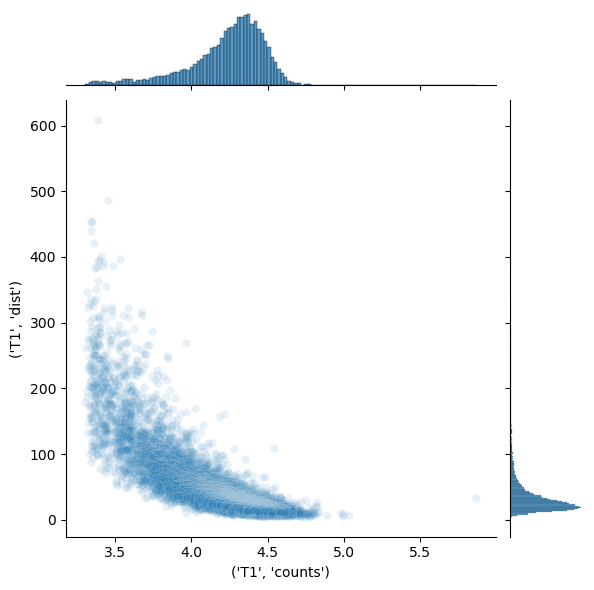

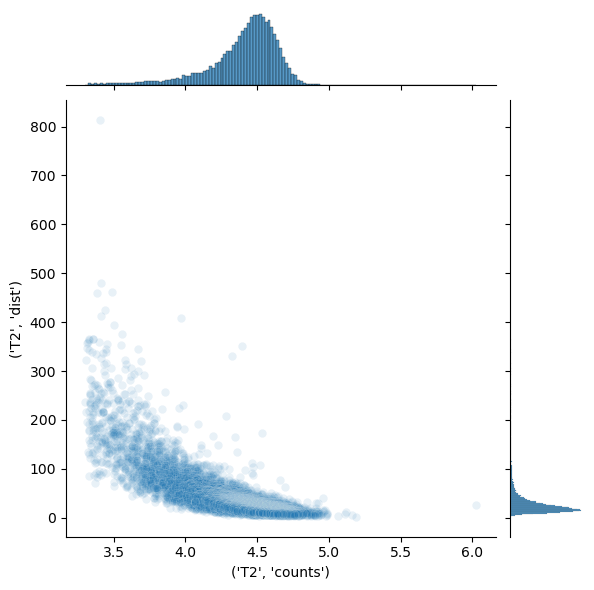

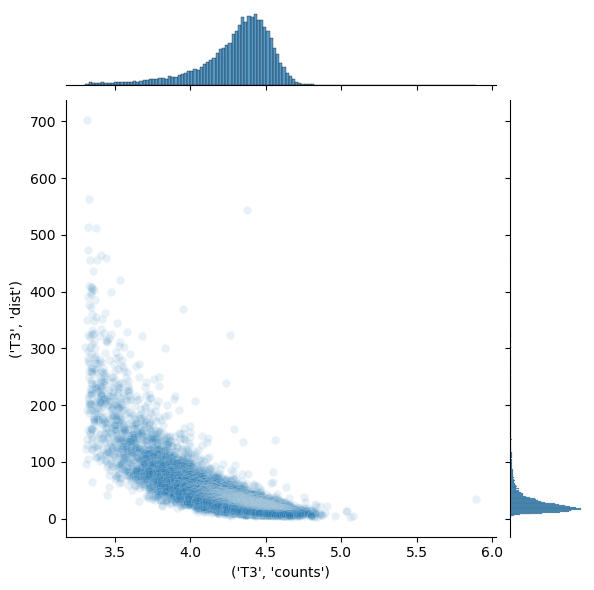

In [42]:
for t in ["T1", "T2", "T3"]:
    x = df[(t, "counts")]
    ge0 = x > 0
    x = x[ge0]
    y = df[(t, "dist")]
    y = y[ge0]
    sns.jointplot(x=np.log10(x), y=y, alpha=0.1)

### Can we visualise the principle components?

If we use the logratio transforms, our interpretation has to change. Now components which varied a lot in by large numbers will differ by small numbers in the log ratio space. This means they have the smallest variation in the PC space. Features with smaller values will vary by larger ratios and thus have more "variation" in the transformed space and thus get captured by the higher components.

This lines up nicely with the literature that the outliers should be captured in the smaller components. 

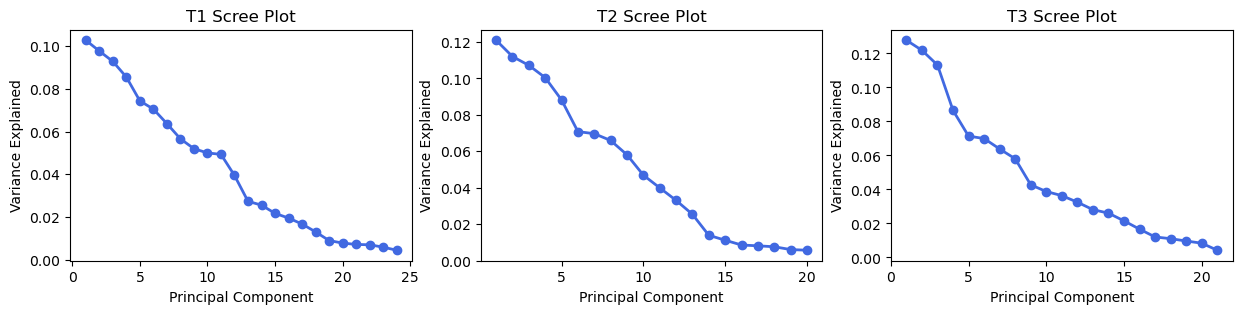

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))

for i, t in enumerate(["T1", "T2", "T3"]):
    explained_variance_ratio = results["mcd_output"][t][0]["eigenvalues"]
    explained_variance_ratio = explained_variance_ratio/explained_variance_ratio.sum()
    PC_values = np.arange(len(explained_variance_ratio)) + 1
    ax[i].plot(PC_values, explained_variance_ratio/explained_variance_ratio.sum(), 'o-', linewidth=2, color='royalblue')
    ax[i].set_title('{} Scree Plot'.format(t))
    ax[i].set_xlabel('Principal Component')
    ax[i].set_ylabel('Variance Explained')
plt.show()

In [ ]:
t = "T3"

Y = results["profiles"][t][0]
print(Y.shape)

cov = results["mcd_output"][t][0]["cov"]
T = cov.location_
C = cov.covariance_
G_z = results["mcd_output"][t][0]["eigenvectors"]
G_z_inv = np.linalg.inv(G_z)
L_z = results["mcd_output"][t][0]["eigenvalues"]
D = Y.shape[1]
V = np.array([np.sqrt(i/(i+1)) * np.concatenate((np.repeat(1/i, i), np.array([-1]), np.repeat(0, D - i - 1))) for i in range(1, D)]).T
print(V.shape)
print(L_z.shape)
Z = results["mcd_output"][t][0]["Z"]
print(Z.shape)
C_y = V @ G_z * L_z @ G_z_inv @ V.T
print(C_y.shape)
G_y = V @ G_z
print(G_y.shape)

Z_t = (Z - T.T) @ G_z 
Y_t = Z_t @ V.T
print(Y_t.shape)


# Y_t is not the PCA scores, I think
pca_scores = Y_t
loadings = G_y
explained_variance_ratio = L_z/L_z.sum()

(17884, 22)
(22, 21)
(21,)
(17884, 21)
(22, 22)
(22, 21)
(17884, 22)


In [ ]:
# TODO: do we need to add zero eigenvector and zero eigenvalue to loadings and explained_variance_ratio?

# explained_variance_ratio = np.pad(explained_variance_ratio, (0,1), 'constant', constant_values=(0))
# loadings = np.pad(loadings, (0,1), 'constant', constant_values=(0))[:-1,:]

# print(pca_scores.shape)
# print(loadings.shape)
# print(explained_variance_ratio.shape)


In [ ]:
df.head()

All                   T1                          T2              \
       Rank total_score   counts        dist pvalue   counts        dist   
Gene                                                                       
Ngdn    1.0   22.600537      0.0         NaN    NaN   2544.0  813.077557   
Zfp72   2.0   17.205542   3132.0  156.588501    0.0   8089.0  120.076338   
Fbxw21  3.0   14.523544   2434.0  608.230802    0.0   4011.0  238.879279   
Orc4    4.0   13.624308      0.0         NaN    NaN   3443.0  220.468247   
Xrcc6   5.0   13.146685  15251.0  156.178579    0.0  24826.0  350.430606   

                           T3                            
              pvalue   counts        dist        pvalue  
Gene                                                     
Ngdn    0.000000e+00      0.0         NaN           NaN  
Zfp72   1.110223e-16   2048.0  702.383536  0.000000e+00  
Fbxw21  0.000000e+00   3311.0  118.118256  6.661338e-16  
Orc4    0.000000e+00   2139.0  563.312266  0.000000e+00  
Xrcc6   0.000000e+00  23812.0  544.764606  0.000000e+00

In [ ]:
num_pc = loadings.shape[1]
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame(loadings, columns=pc_list)
loadings_df['variable'] = Y.columns.to_list()
loadings_df = loadings_df.set_index('variable')
loadings_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21
variable,,,,,,,,,,,,,,,,,,,,,
"1bp insertion - G, 0",0.004538,0.015428,0.048951,0.028965,0.029158,0.021543,-0.018763,0.052078,0.010278,0.018772,...,-0.038205,0.044203,0.004528,-0.047930,0.164533,0.111221,-0.222432,0.001094,-0.027688,0.921962
">1bp insertion, 0",0.025126,0.026679,0.130369,0.095115,0.282779,0.245166,-0.709006,-0.519968,-0.028519,-0.033066,...,0.062577,-0.028927,-0.007697,0.035797,-0.044224,-0.017505,0.042413,-0.008835,0.000081,-0.031480
"Deletion 0bp microhomology, 1",-0.006571,0.009446,0.061947,0.040783,0.014858,0.009587,-0.027794,0.134114,-0.004093,0.071537,...,-0.170009,0.556681,0.651582,0.293866,-0.224199,-0.029188,0.050761,-0.002109,0.026852,-0.033553
"Deletion 0bp microhomology, 4",0.658120,-0.577376,-0.421373,-0.069208,-0.007199,-0.025003,0.015101,-0.059906,0.002845,0.006070,...,0.013264,-0.008619,0.000658,0.018700,-0.017638,0.003608,-0.002677,0.002472,0.006488,-0.009481
"Deletion 1bp microhomology, 16",-0.746040,-0.425652,-0.457817,-0.026351,0.002175,-0.015790,-0.015936,-0.067500,-0.000140,-0.018511,...,0.015899,-0.015374,0.001156,0.008694,-0.013645,-0.001219,0.003693,0.005569,0.001946,-0.003329


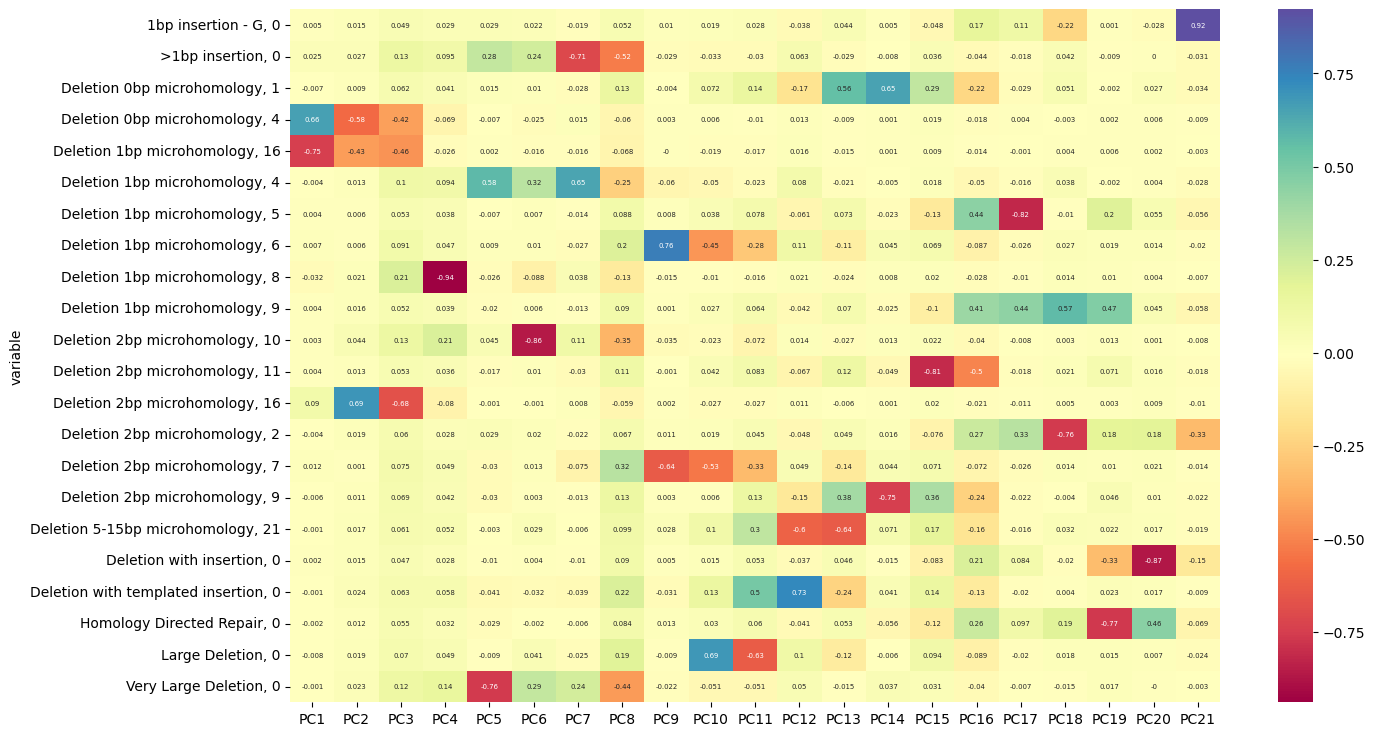

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 9))
ax = sns.heatmap(loadings_df.round(3), annot=True, cmap='Spectral', annot_kws={"fontsize":5})
plt.show()

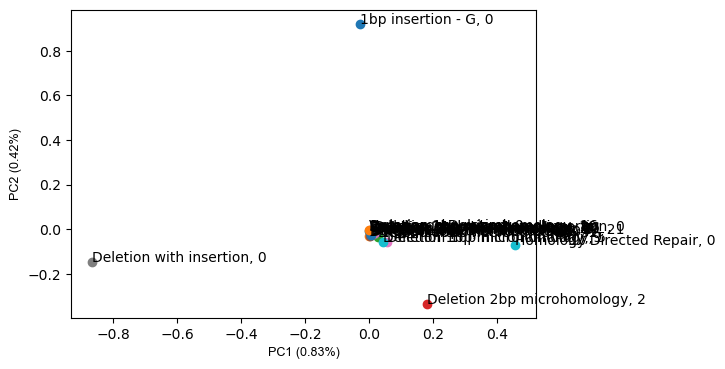

In [ ]:
PCx = -2
PCy = -1

cluster.pcaplot(x=loadings[:,PCx], y=loadings[:,PCy], labels=Y.columns.values, 
    var1=round(explained_variance_ratio[PCx]*100, 2),
    var2=round(explained_variance_ratio[PCy]*100, 2), show=True)

In [ ]:
df.loc["Lig4"][("All", "Rank")]

687.0

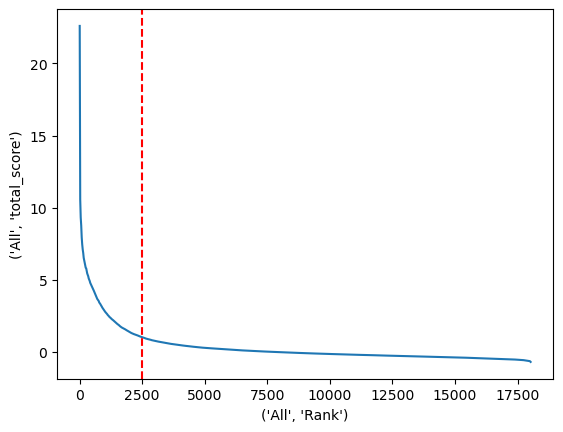

In [ ]:
# where do we apply the threshold?
# can try the elbow method...
sns.lineplot(data=df.iloc[::20, :], x=("All", "Rank"), y=("All", "total_score"))
plt.axvline(2500, ls="--", c='r')
plt.show()

### What are some genes of interest?


| Gene  | Known Function   |Impact on Repair Outcome Profile   |   |   |
|---|---|---|---|---|
| Rrm1  |   |   |   |   |
| Orc4  |   |   |   |   |
|   |   |   |   |   |

/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_7604/4000040690.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)


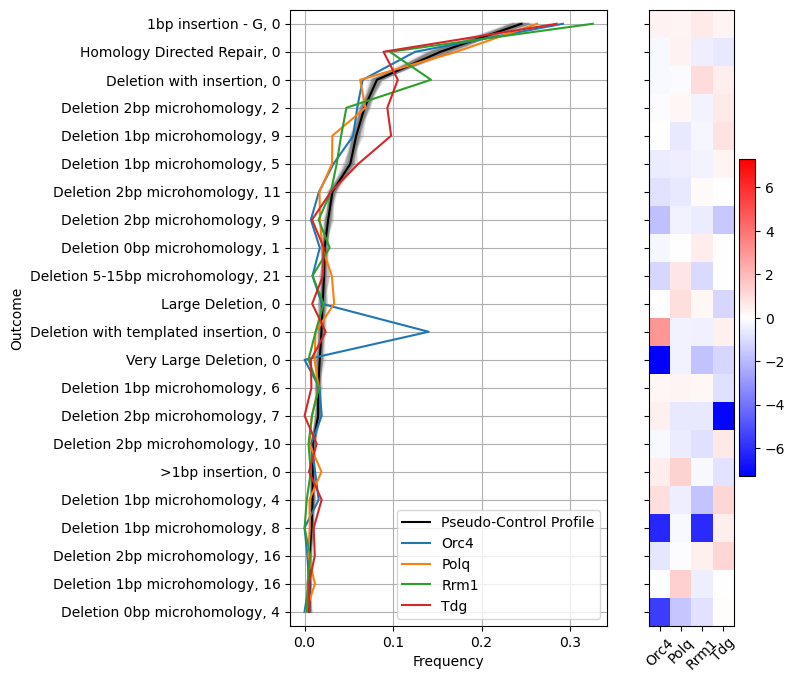

In [ ]:
# investigate target site 2
with plt.style.context('fast'):
    pseudo_controls = df.tail(100)
    psudeo_control_profile = results["profiles"][t][0].loc[results["profiles"][t][0].index.isin(pseudo_controls.index)]
    psudeo_control_avg_profile = psudeo_control_profile.mean()
    psudeo_control_avg_profile

    t_results = results["profiles"][t][0]
    t_results = t_results.replace({0: 0.0001})
    t_results = t_results.div(t_results.sum(axis=1), axis=0)

    logfolddf = np.log2(t_results/psudeo_control_avg_profile)
    logfolddf.head()

    linepdata = psudeo_control_profile.T
    outcome_order = list(linepdata.T.mean().sort_values(ascending=False).index)
    compare_genes = ["Orc4", "Rrm1", "Polq", "Tdg"]
    compare_genes = list(np.intersect1d(compare_genes, results["profiles"][t][0].index))

    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(6, 8), gridspec_kw={'width_ratios': [3, 1]})
    ax = axs[0]

    for col in linepdata.columns:
        p = linepdata.loc[outcome_order, col].reset_index()
        y = p.index
        x = p[col]
        labels = p["Feature"]
        ax.plot(x, y, color="grey", alpha=0.1)


    ax.plot(linepdata.loc[outcome_order,:].mean(axis=1), y, color="black", label="Pseudo-Control Profile")

    for gene in compare_genes:
        p = results["profiles"][t][0].T.loc[outcome_order, gene].reset_index()
        y = p.index
        x = p[gene]
        labels = p["Feature"]
        ax.plot(x, y, label=gene)

    ax.legend()
    ax.set_yticks(y, labels)
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Outcome")
    ax.grid()

    ax2 = axs[1]
    limit = logfolddf.loc[compare_genes].abs().max().max()
    im = ax2.imshow(logfolddf.loc[compare_genes, outcome_order].T, vmax=limit, vmin=-limit, cmap='bwr', aspect='auto')
    plt.colorbar(im)
    ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)
    ax2.set_xticks(np.arange(len(compare_genes)), compare_genes)

# sns.heatmap(logfolddf.loc[compare_genes, outcome_order].T, ax=ax2, center=0)
plt.show()

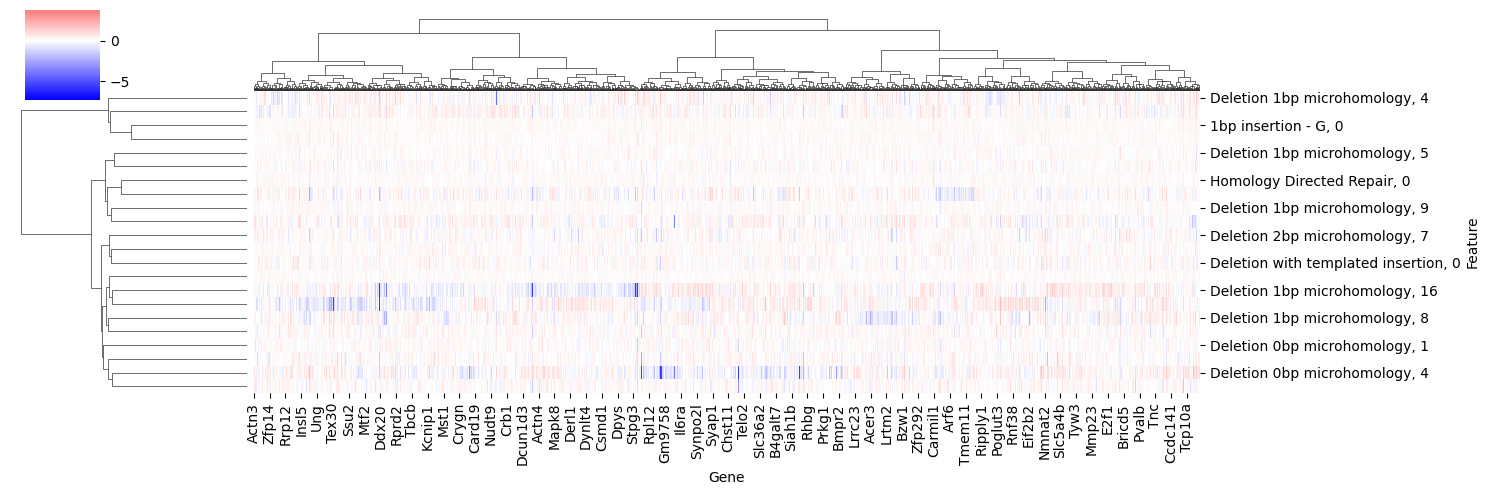

In [ ]:
sns.clustermap(logfolddf.T, method="ward", metric="correlation", center=0, cmap="bwr", figsize=(15, 5))
plt.show()

In [ ]:
import statsmodels.api as sm

X = logfolddf
y = df.loc[logfolddf.index, ("All", "total_score")]

X = sm.add_constant(X) # add a constant
model = sm.OLS(y, X).fit()

In [ ]:
model_summary = pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0]
model_summary["abs(coef)"] = model_summary["coef"].abs()
model_summary.sort_values("abs(coef)", ascending=False).head(20)

,coef,std err,t,P>|t|,[0.025,0.975],abs(coef)
"1bp insertion - G, 0",-15.5207,0.125,-123.996,0.0,-15.766,-15.275,15.5207
"Homology Directed Repair, 0",-9.6812,0.063,-152.938,0.0,-9.805,-9.557,9.6812
const,8.1372,0.051,160.151,0.0,8.038,8.237,8.1372
"Deletion with insertion, 0",-5.2543,0.047,-112.273,0.0,-5.346,-5.163,5.2543
"Deletion 2bp microhomology, 2",-4.2170,0.045,-93.943,0.0,-4.305,-4.129,4.2170
"Deletion 1bp microhomology, 9",-3.7692,0.036,-104.090,0.0,-3.840,-3.698,3.7692
"Deletion 1bp microhomology, 5",-3.3409,0.034,-98.718,0.0,-3.407,-3.275,3.3409
"Deletion 2bp microhomology, 11",-2.0637,0.026,-80.861,0.0,-2.114,-2.014,2.0637
"Deletion 2bp microhomology, 9",-1.7047,0.022,-78.298,0.0,-1.747,-1.662,1.7047
"Deletion 0bp microhomology, 1",-1.4909,0.021,-69.821,0.0,-1.533,-1.449,1.4909


In [ ]:
import hdbscan
from sklearn.metrics.pairwise import pairwise_distances


clusterer = hdbscan.HDBSCAN(metric="precomputed", min_cluster_size=3)
distances = pairwise_distances(logfolddf, metric="correlation")
clusterer.fit(distances)
unique, counts = np.unique(clusterer.labels_, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   -1  4771]
 [    0     3]
 [    1     3]
 [    2     4]
 [    3 13100]
 [    4     3]]


### How do they compare to the genes identified by Marco?

In [ ]:
from src.config import HOME_PATH

In [ ]:
genesubset2 = pd.read_csv(HOME_PATH + "/repos/MUSICian/src/data/GeneSubset2.txt", sep="\t")["Gene"]
genesubset2.shape

(52,)

In [ ]:
X.index.isin([genesubset2[np.invert(genesubset2.isin(significant_gene_profiles.index))]])

array([False, False, False, ..., False, False, False])

In [ ]:
significant_gene_profiles.loc[~significant_gene_profiles.index.isin(genesubset2)]

,T1,T2,T3
Gene,,,
Fam111a,True,True,True
Ik,True,True,True
Vmn2r7,True,True,True
Vmn2r68,True,True,True
Vmn2r66,True,True,True
...,...,...,...
Defa40,NaN,NaN,True
Psmg4,NaN,NaN,True
Sult2a2,NaN,NaN,True


In [ ]:
genesubsetSD30 = pd.read_csv(HOME_PATH + "/repos/MUSICian/src/data/GeneSubsetSD30.txt", sep="\t")["Gene"]
genesubsetSD30.shape

(628,)

In [ ]:
genesubsetSD30[np.invert(genesubsetSD30.isin(significant_gene_profiles.index))]

12        Ccnjl
13       Spata2
38     Vmn1r167
45       Polr2j
60        Ccnl1
         ...   
602        Ilf3
603        Fdxr
605       Ndel1
617        Ldlr
622       Hdlbp
Name: Gene, Length: 138, dtype: object

In [ ]:
df.loc[df.index.isin(genesubsetSD30[np.invert(genesubsetSD30.isin(significant_gene_profiles.index))])].shape

(43, 11)

In [ ]:
df.loc[df.index.isin(genesubsetSD30) & (df[("All", "Rank")] > 2500)]

All                   T1                                T2  \
                  Rank total_score   counts       dist        pvalue   counts   
Gene                                                                            
Ccdc175         2535.0    0.985800  12267.0  37.204498  3.094530e-02  18656.0   
Btaf1           2545.0    0.982407   7943.0  77.028675  9.547712e-08  14988.0   
Zfp53           2546.0    0.981170   6487.0  45.784943  3.180870e-03  13990.0   
1700025G04Rik   2548.0    0.979428   5404.0  76.911816  9.967314e-08  11062.0   
Ahctf1          2552.0    0.976782   4756.0  52.988759  3.677726e-04  13047.0   
...                ...         ...      ...        ...           ...      ...   
Prr30          14457.0   -0.367949  31149.0  17.887944  7.635388e-01  42417.0   
Ehd3           14497.0   -0.369839  31731.0  13.775282  9.331260e-01  43526.0   
Marchf6        14870.0   -0.386977  23065.0  20.802883  5.931239e-01  36379.0   
Nf2            15022.0   -0.393984  34086.0  20.256151  6.264143e-01  43537.0   
Ccnl1          16002.0   -0.444934  19729.0  21.035878  5.788964e-01  30468.0   

                                             T3                           
                    dist        pvalue   counts       dist        pvalue  
Gene                                                                      
Ccdc175        56.225066  1.506257e-05  14446.0  72.516854  7.033950e-08  
Btaf1          52.187515  6.201810e-05  11947.0  57.155093  1.944328e-05  
Zfp53          65.264764  5.529492e-07   9741.0  55.333445  3.660511e-05  
1700025G04Rik  40.463828  2.842915e-03   6767.0  44.245227  1.395173e-03  
Ahctf1         56.744045  1.252001e-05   7703.0  72.166636  8.034585e-08  
...                  ...           ...      ...        ...           ...  
Prr30          13.255243  8.252519e-01  34148.0  19.946245  4.612968e-01  
Ehd3           16.558239  6.197685e-01  32975.0  19.872845  4.659088e-01  
Marchf6        17.940621  5.264079e-01  29593.0  15.841169  7.264277e-01  
Nf2            10.691161  9.337904e-01  38569.0  18.935206  5.260412e-01  
Ccnl1          14.238711  7.696020e-01  24658.0  16.167138  7.062027e-01  

[137 rows x 11 columns]

In [ ]:
from src.config import get_adamson
hussmann_repair_genes = pd.read_csv(get_adamson(), sep="\t", header=None)[0]
hussmann_repair_genes.shape

(442,)

In [ ]:
significant_gene_profiles.index.shape

(6630,)

In [ ]:
hussmann_repair_genes[np.invert(hussmann_repair_genes.isin(significant_gene_profiles.index))]

1       Actr5
2       Actr8
3       Aicda
4      Alkbh2
7       Apex1
        ...  
424     Uvssa
430       Xpc
431     Xrcc1
437      Ybx3
439       Yy1
Name: 0, Length: 174, dtype: object

In [ ]:
X.index

Index(['0610009B22Rik', '0610010K14Rik', '0610030E20Rik', '0610040J01Rik',
       '1110004F10Rik', '1110017D15Rik', '1110032A03Rik', '1110032F04Rik',
       '1110059E24Rik', '1110059G10Rik',
       ...
       'Zxdb', 'Zxdc', 'Zyg11a', 'Zyg11b', 'Zyx', 'Zzef1', 'Zzz3', 'a',
       'ccdc198', 'mei-04'],
      dtype='object', name='Gene', length=17884)

In [ ]:
hussmann_repair_genes[np.invert(hussmann_repair_genes.isin(significant_gene_profiles.index))]

1       Actr5
2       Actr8
3       Aicda
4      Alkbh2
7       Apex1
        ...  
424     Uvssa
430       Xpc
431     Xrcc1
437      Ybx3
439       Yy1
Name: 0, Length: 174, dtype: object

In [ ]:
X.loc[X.index.isin(hussmann_repair_genes[np.invert(hussmann_repair_genes.isin(significant_gene_profiles.index))])]

,const,"1bp insertion - G, 0",">1bp insertion, 0","Deletion 0bp microhomology, 1","Deletion 0bp microhomology, 4","Deletion 1bp microhomology, 16","Deletion 1bp microhomology, 4","Deletion 1bp microhomology, 5","Deletion 1bp microhomology, 6","Deletion 1bp microhomology, 8",...,"Deletion 2bp microhomology, 16","Deletion 2bp microhomology, 2","Deletion 2bp microhomology, 7","Deletion 2bp microhomology, 9","Deletion 5-15bp microhomology, 21","Deletion with insertion, 0","Deletion with templated insertion, 0","Homology Directed Repair, 0","Large Deletion, 0","Very Large Deletion, 0"
Gene,,,,,,,,,,,,,,,,,,,,,
Actr5,1.0,0.021575,0.214638,0.288051,0.175062,0.086621,0.023256,0.376904,0.049436,0.177746,...,0.080572,0.200193,0.115434,-0.155698,0.154843,0.267584,0.286865,0.274298,-0.111256,0.086990
Actr8,1.0,0.308216,0.401116,0.450563,0.069223,-0.084208,0.496298,0.120706,0.473565,-0.571686,...,0.111983,0.389297,-0.280464,-0.141122,0.031932,0.043629,-0.190555,0.119916,-0.413685,-0.397259
Aicda,1.0,0.213522,0.367089,0.163333,-0.260417,0.953321,0.735457,0.341671,0.084120,0.702012,...,-0.591200,0.243075,-0.306637,0.130189,0.144748,0.123292,-0.137141,0.025391,0.041010,-0.081510
Alkbh2,1.0,0.075446,0.160929,0.304953,0.955766,0.221379,-0.120154,0.077655,0.145204,0.247317,...,-0.537939,0.193874,0.146324,0.177670,0.226724,0.156366,0.118543,0.105987,0.261128,-0.080393
Apex1,1.0,0.185672,0.793593,0.017038,0.370826,0.090737,0.485248,0.048275,-0.114306,0.027350,...,0.046623,0.318753,-0.294211,0.276810,-0.032148,0.105394,0.324011,0.141459,0.423950,-0.109545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Uvssa,1.0,0.247259,0.053882,0.487860,-0.602540,-0.011706,-0.161185,0.214660,0.158904,-0.092788,...,0.301790,-0.104512,0.328117,-0.009505,0.083171,0.248536,0.113501,0.108956,0.425545,-0.526549
Xpc,1.0,0.211085,0.397461,0.210695,0.135246,-0.279747,-0.063668,-0.076204,0.203667,-0.528132,...,-0.298124,0.221597,0.234713,0.062686,0.358551,0.136282,0.737687,0.088635,0.019202,0.304732
Xrcc1,1.0,0.185184,0.622944,0.074890,-0.124651,0.033028,0.426955,0.088988,0.198168,0.616255,...,0.001297,0.164031,-0.238409,0.582253,-0.235637,0.237874,0.219237,0.171795,0.384228,-0.153288


In [ ]:
gene = "Zfp72"
(gene in genesubset2) or (gene in genesubsetSD30) or (gene in hussmann_repair_genes)

False